In [2]:
import numpy as np
import time
# import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import *
from keras.callbacks import ModelCheckpoint

2022-06-19 22:28:48.997492: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17416481350205870508
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4602986496
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6761447835372214301
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


2022-06-19 22:22:50.187181: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-19 22:22:50.406483: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 22:22:50.661635: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 22:22:50.663109: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

In [3]:
''' 
期末作業進行步驟：
1: read train_set.json
2: 依train_set.json 獲得所有 training data pair(image, target_dict)
3: resize all iamge
4: training
5: test (以此數據進行評分)


提示：
1: model input: resized image in train_set (test_set同樣做法)
2: model output: resized plate_dict['車牌角點'] in train_set (test_set同樣做法)
3: model 不是分類問題，而是regression問題 (與作業 autoEncoder 類似)

'''

import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import time
%matplotlib inline

#ROOT_DIR = os.getcwd()
ROOT_DIR = './'

# input path
Dataset_Dir = os.path.join(ROOT_DIR, 'car_dataset')


# read train/test set
name = os.path.join(ROOT_DIR, 'train_set.json')
with open(name, 'r') as file:
    train_files = json.load(file)
    
name = os.path.join(ROOT_DIR, 'test_set.json')
with open(name, 'r') as file:
    test_files = json.load(file)
    
print('train_files:', len(train_files), train_files[0])
print('test_files:', len(test_files), test_files[0])

train_files: 10000 05694
test_files: 2063 00004


In [4]:
# test: read pair: .jpg & .json
def get_pair_info(name):
    f1 = name + '.json'
    with open(f1, 'r') as file:
        jdict = json.load(file)
        
    f2 = name + '.jpg'
    img = cv2.imdecode( np.fromfile(f2, dtype=np.uint8), -1)
    return img, jdict

# 範例
case_file = train_files[0] # 第 1 筆資料
name = os.path.join(Dataset_Dir, case_file)
src_img, plate_dict = get_pair_info(name)

print('src_img:', src_img.shape)
print('plate_dict:', plate_dict)

src_img: (316, 414, 3)
plate_dict: {'車牌號碼': '7422NE', '車牌類型': '白底黑字', '車牌位置': [135, 145, 201, 173], '車牌角點': [137, 145, 201, 146, 201, 173, 135, 172]}


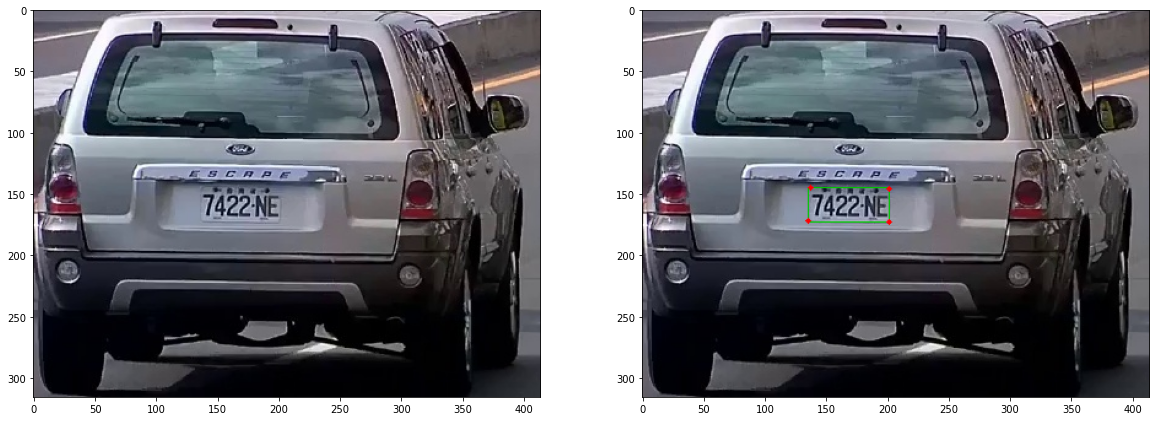

In [5]:
Red_color = (0, 0, 255) # BGR format
Green_color = (0, 200, 0)
radius = 2

draw_img = src_img.copy()
x1,y1, x2,y2 = plate_dict['車牌位置']
px1,py1, px2,py2, px3,py3, px4,py4 = plate_dict['車牌角點']

cv2.rectangle(draw_img, (x1,y1), (x2,y2), Green_color, 1)
cv2.circle(draw_img, (px1,py1),  radius, Red_color, -1)
cv2.circle(draw_img, (px2,py2),  radius, Red_color, -1)
cv2.circle(draw_img, (px3,py3),  radius, Red_color, -1)
cv2.circle(draw_img, (px4,py4),  radius, Red_color, -1)

plt.figure(figsize=(20,10))
plt.subplot(121); plt.imshow(src_img[:,:,::-1])
plt.subplot(122); plt.imshow(draw_img[:,:,::-1])

src_img: (377, 673, 3)
plate_dict: {'車牌號碼': '2682G', '車牌類型': '白底紅字', '車牌位置': [187, 275, 311, 346], '車牌角點': [195, 275, 311, 285, 305, 346, 187, 331]}


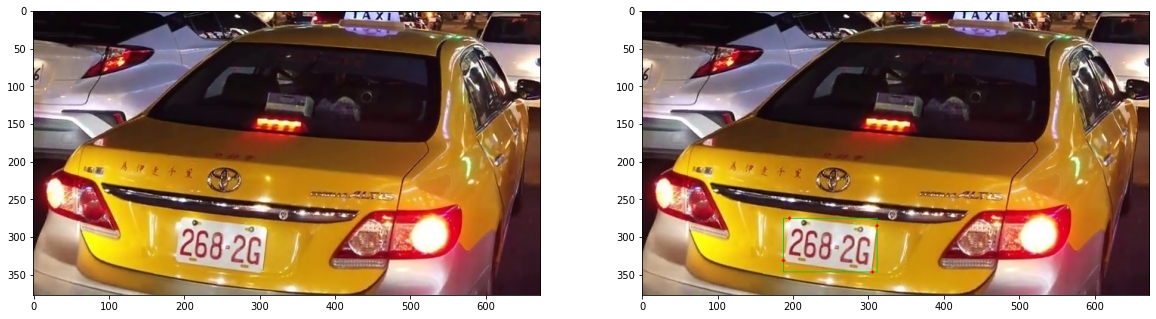

In [6]:
# 範例
case_file = train_files[20] # 第 1 筆資料
name = os.path.join(Dataset_Dir, case_file)
src_img, plate_dict = get_pair_info(name)

print('src_img:', src_img.shape)
print('plate_dict:', plate_dict)

Red_color = (0, 0, 255) # BGR format
Green_color = (0, 200, 0)
radius = 2

draw_img = src_img.copy()
x1,y1, x2,y2 = plate_dict['車牌位置']
px1,py1, px2,py2, px3,py3, px4,py4 = plate_dict['車牌角點']

cv2.rectangle(draw_img, (x1,y1), (x2,y2), Green_color, 1)
cv2.circle(draw_img, (px1,py1),  radius, Red_color, -1)
cv2.circle(draw_img, (px2,py2),  radius, Red_color, -1)
cv2.circle(draw_img, (px3,py3),  radius, Red_color, -1)
cv2.circle(draw_img, (px4,py4),  radius, Red_color, -1)

plt.figure(figsize=(20,10))
plt.subplot(121); plt.imshow(src_img[:,:,::-1])
plt.subplot(122); plt.imshow(draw_img[:,:,::-1])

In [7]:
def img_resize(image,size_x,size_y):
    data_image=cv2.resize(image,(size_x,size_y),
                          interpolation=cv2.INTER_AREA)
    data_image=data_image/255
    return data_image

def label_resize(size_x,size_y,px1,py1, px2,py2, px3,py3, px4,py4,src_img):
    x1=round(px1*(size_x/src_img.shape[1]))
    y1=round(py1*(size_y/src_img.shape[0]))
    x2=round(px2*(size_x/src_img.shape[1]))
    y2=round(py2*(size_y/src_img.shape[0]))
    x3=round(px3*(size_x/src_img.shape[1]))
    y3=round(py3*(size_y/src_img.shape[0]))
    x4=round(px4*(size_x/src_img.shape[1]))
    y4=round(py4*(size_y/src_img.shape[0]))
    return [x1,y1,x2,y2,x3,y3,x4,y4]

def draw(data_image,x1,y1,x2,y2,x3,y3,x4,y4):
    Red_color = (0, 0, 255)
    radius = 2
    cv2.circle(data_image, (x1,y1),  radius, Red_color, -1)
    cv2.circle(data_image, (x2,y2),  radius, Red_color, -1)
    cv2.circle(data_image, (x3,y3),  radius, Red_color, -1)
    cv2.circle(data_image, (x4,y4),  radius, Red_color, -1)
    plt.figure(figsize=(20,10))
    plt.subplot(121); plt.imshow(data_image[:,:,::-1])

def draw_2(data_image,label):
    Red_color = (0, 0, 255)
    radius = 2
    cv2.circle(data_image, (label[0],label[1]),  radius, Red_color, -1)
    cv2.circle(data_image, (label[2],label[3]),  radius, Red_color, -1)
    cv2.circle(data_image, (label[4],label[5]),  radius, Red_color, -1)
    cv2.circle(data_image, (label[6],label[7]),  radius, Red_color, -1)
    plt.figure(figsize=(20,10))
    plt.subplot(121); plt.imshow(data_image[:,:,::-1])

def draw_3(data_image,label,test_label):
    Red_color = (0, 0, 255)
    Green_color = (0, 200, 0)
    radius = 2
    cv2.circle(data_image, (label[0],label[1]),  radius, Red_color, -1)
    cv2.circle(data_image, (label[2],label[3]),  radius, Red_color, -1)
    cv2.circle(data_image, (label[4],label[5]),  radius, Red_color, -1)
    cv2.circle(data_image, (label[6],label[7]),  radius, Red_color, -1)
    cv2.circle(data_image, (test_label[0],test_label[1]),  radius, Green_color, -1)
    cv2.circle(data_image, (test_label[2],test_label[3]),  radius, Green_color, -1)
    cv2.circle(data_image, (test_label[4],test_label[5]),  radius, Green_color, -1)
    cv2.circle(data_image, (test_label[6],test_label[7]),  radius, Green_color, -1)
    plt.figure(figsize=(20,10))
    plt.subplot(121); plt.imshow(data_image[:,:,::-1])

In [8]:
# image size
size_x, size_y = 256, 256

train_data=np.zeros((len(train_files),size_x,size_y,3),dtype=float)
train_label=np.zeros((len(train_files),8),dtype=int)

test_data=np.zeros((len(test_files),size_x,size_y,3),dtype=float)
test_label=np.zeros((len(test_files),8),dtype=int)

for i in range(len(test_files)):
    case_file = test_files[i]
    name = os.path.join(Dataset_Dir, case_file)
    src_img, plate_dict = get_pair_info(name)
    test_data_image=img_resize(src_img,size_x,size_y)
    px1,py1, px2,py2, px3,py3, px4,py4 = plate_dict['車牌角點']
    test_data_label=label_resize(size_x,size_y,px1,py1, px2,py2, px3,py3, px4,py4,src_img)
    test_label[i]=test_data_label
    test_data[i]=test_data_image

for i in range(len(train_files)):
    case_file = train_files[i]
    name = os.path.join(Dataset_Dir, case_file)
    src_img, plate_dict = get_pair_info(name)
    train_data_image=img_resize(src_img,size_x,size_y)
    px1,py1, px2,py2, px3,py3, px4,py4 = plate_dict['車牌角點']
    train_data_label=label_resize(size_x,size_y,px1,py1, px2,py2, px3,py3, px4,py4,src_img)
    train_label[i]=train_data_label
    train_data[i]=train_data_image

print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(10000, 256, 256, 3)
(10000, 8)
(2063, 256, 256, 3)
(2063, 8)


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_data, train_label, test_size=0.2, random_state=11)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


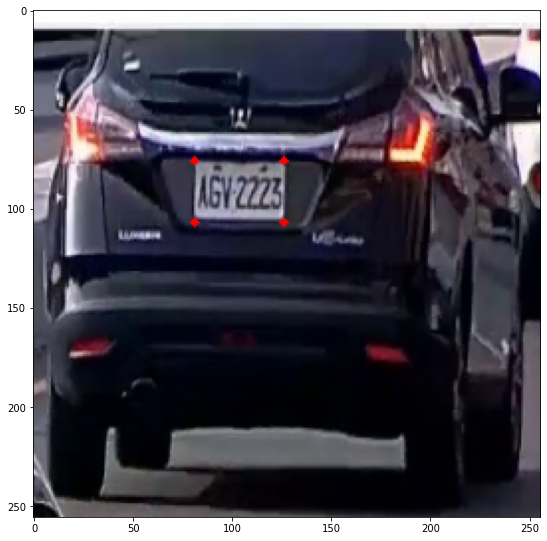

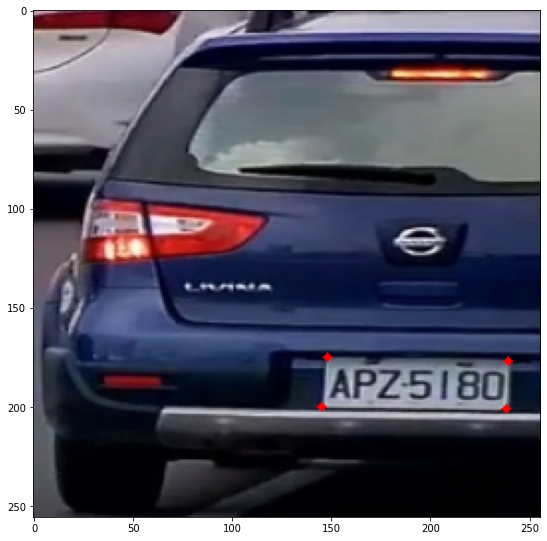

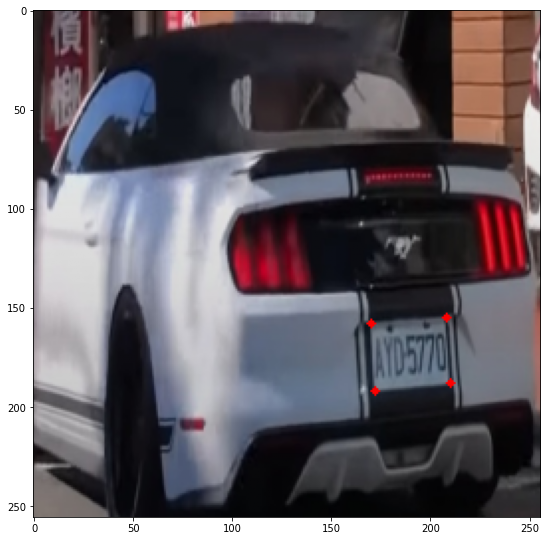

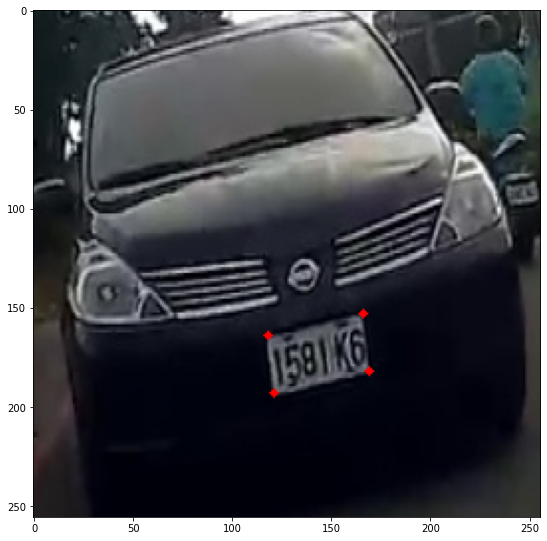

In [10]:
for i in range(4):
    # train
    train_see = X_train[i]
    label_see = y_train[i]
    draw_2(train_see,label_see)

In [4]:
model = tf.keras.Sequential()

#conv1
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=[3, 3], input_shape=(size_x,size_y, 3), strides=1,activation='relu',
                                        padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))
#conv2
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=[3, 3], strides=1,activation='relu',
                                        padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
model.add(tf.keras.layers.BatchNormalization()) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))


#conv3
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=[3, 3], strides=1,activation='relu',
                                        padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
model.add(tf.keras.layers.BatchNormalization()) 
model.add(tf.keras.layers.Dropout(0.4))
#conv4
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=[3, 3], strides=1,activation='relu',
                                        padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
model.add(tf.keras.layers.BatchNormalization()) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))



#conv5
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=[3, 3], strides=1,activation='relu',
                                        padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
model.add(tf.keras.layers.BatchNormalization()) 
model.add(tf.keras.layers.Dropout(0.4))
#conv6
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=[3, 3], strides=1,activation='relu',
                                        padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
model.add(tf.keras.layers.BatchNormalization()) 
model.add(tf.keras.layers.Dropout(0.4))
#conv7
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=[3, 3], strides=1,activation='relu',
                                        padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
model.add(tf.keras.layers.BatchNormalization()) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))


#conv8
model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=[3, 3], strides=1,activation='relu',
                                        padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
model.add(tf.keras.layers.BatchNormalization()) 
model.add(tf.keras.layers.Dropout(0.4))
#conv9
model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=[3, 3], strides=1,activation='relu',
                                        padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
model.add(tf.keras.layers.BatchNormalization()) 
model.add(tf.keras.layers.Dropout(0.4))
#conv10
model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=[3, 3], strides=1,activation='relu',
                                        padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
model.add(tf.keras.layers.BatchNormalization()) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))


#conv11
model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=[3, 3], strides=1,activation='relu',
                                        padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
model.add(tf.keras.layers.BatchNormalization()) 
model.add(tf.keras.layers.Dropout(0.4))
#conv12
model.add(tf.keras.layers.Conv2D(filters=1024, kernel_size=[3, 3], strides=1,activation='relu',
                                        padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
model.add(tf.keras.layers.BatchNormalization()) 
model.add(tf.keras.layers.Dropout(0.4))
#conv13
model.add(tf.keras.layers.Conv2D(filters=1024, kernel_size=[3, 3], strides=1,activation='relu',
                                        padding='SAME', kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
model.add(tf.keras.layers.BatchNormalization()) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(rate=0.5))


model.add(tf.keras.layers.Dense(units=512,activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0005)))
model.add(tf.keras.layers.BatchNormalization())


model.add(tf.keras.layers.Dense(units=8))
model.summary()

2022-06-19 22:29:22.353752: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 22:29:22.612538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 22:29:22.613982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 22:29:22.617692: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

NameError: name 'size_x' is not defined

In [5]:
batch_size=8
#adam = Adam(learning_rate=0.01)
sgd = SGD(lr=1e-2, clipnorm=1.)    #1e-3 
model.compile(loss='mean_squared_error', optimizer=sgd)
epochs=10
filepath="./model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True,
mode='min')
callbacks_list = [checkpoint]
train_history = model.fit(X_train,y_train,batch_size=batch_size,epochs=epochs, verbose=1,
                        validation_data=(X_val, y_val),callbacks=callbacks_list)

NameError: name 'X_train' is not defined